## Setting the environment

In [1]:
# Импортируем необходимые библиотеки

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array

from tensorflow.keras.preprocessing.text import Tokenizer, one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, load_model
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Загружаем датасет

In [ ]:
# импортируем датасет

movie_reviews = pd.read_csv("drive/MyDrive/a1_IMDB_Dataset.csv")


In [ ]:
# смотрим размеры датасета

movie_reviews.shape

(50000, 2)

In [ ]:
# просматриваем датасет
movie_reviews.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
# проверяем наличие пропущенных значений в данных
movie_reviews.isnull().values.any()

False

<Axes: xlabel='sentiment', ylabel='count'>

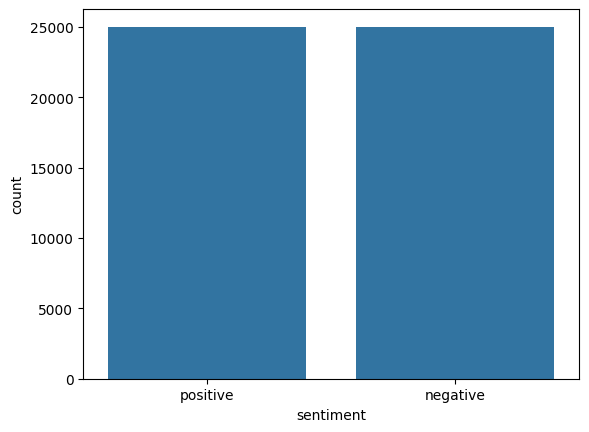

In [ ]:
# рассмотрим распределение положительных и отрицательных классов

import seaborn as sns
sns.countplot(x='sentiment', data=movie_reviews)

## Data Preprocessing

In [ ]:
# видим, что текст содержит html теги. Нужно от них избавиться
movie_reviews["review"][2]


'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

In [ ]:
# создаем функцию удаления html тегов
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# ооздаем функцию обработки текста
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''

    sentence = sen.lower()

    # удаляем html теги
    sentence = remove_tags(sentence)

    # удаляем пунктуацию и числа
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # удалем одиночные символы
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # удаляем лишние пробелы
    sentence = re.sub(r'\s+', ' ', sentence)

    # можно удалить запрещенные слова
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [ ]:
# обрабатываем текст

X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [ ]:
# смотрим очищенные данные

X[2]

'thought wonderful way spend time hot summer weekend sitting air conditioned theater watching light hearted comedy plot simplistic dialogue witty characters likable even well bread suspected serial killer may disappointed realize match point risk addiction thought proof woody allen still fully control style many us grown love laughed one woody comedies years dare say decade never impressed scarlet johanson managed tone sexy image jumped right average spirited young woman may crown jewel career wittier devil wears prada interesting superman great comedy go see friends '

In [ ]:
# конвертируем значения целевого признака в 0\1
y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [ ]:
# разделяем выборку на тренировочную  и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

## Подгатавливаем слой embedding

In [ ]:
word_tokenizer = Tokenizer() # создаем токенайзер
word_tokenizer.fit_on_texts(X_train) # обучаем токенайзер на наших данных

X_train = word_tokenizer.texts_to_sequences(X_train) # преобразуем предложения в числовую форму
X_test = word_tokenizer.texts_to_sequences(X_test)

In [ ]:
# фиксируем размер словаря и прибавляем 1 для паддинга

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

92034

In [ ]:
# фиксируем длину 100 текста, остальным добавляем паддинги

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
# загружаем словарь : слово <-> его векторное представление размером 100
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('drive/MyDrive/a2_glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [ ]:
# создаем матрицу embeddings

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector


In [ ]:
embedding_matrix.shape

(92034, 100)

# Тренировка модели

## Сверточная нейросеть

In [ ]:
from keras.layers import Conv1D

In [ ]:
# архитектура нейросети

cnn_model = Sequential()

# при желании можем использовать свою матрицу embeddings (acc = 85% )
# embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
embedding_layer = Embedding(vocab_length, 100, input_length=maxlen)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Задаем параметры обучения

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          9203400   
                                                                 
 conv1d_2 (Conv1D)           (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d_2 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9267657 (35.35 MB)
Trainable params: 9267657 (35.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
# Обучаем модель

cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=3, verbose=1, validation_split=0.1)

Epoch 1/3
282/282 [==============================] - 30s 100ms/step - loss: 0.4460 - acc: 0.7918 - val_loss: 0.3448 - val_acc: 0.8510
Epoch 2/3
282/282 [==============================] - 16s 58ms/step - loss: 0.2252 - acc: 0.9120 - val_loss: 0.3461 - val_acc: 0.8553
Epoch 3/3
282/282 [==============================] - 13s 46ms/step - loss: 0.0979 - acc: 0.9681 - val_loss: 0.3956 - val_acc: 0.8528


In [ ]:
# Вычисляем метрику на тестовом наборе данных

score = cnn_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 1s 3ms/step - loss: 0.3835 - acc: 0.8542


In [ ]:
# Показатели модели

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.38348373770713806
Test Accuracy: 0.854200005531311


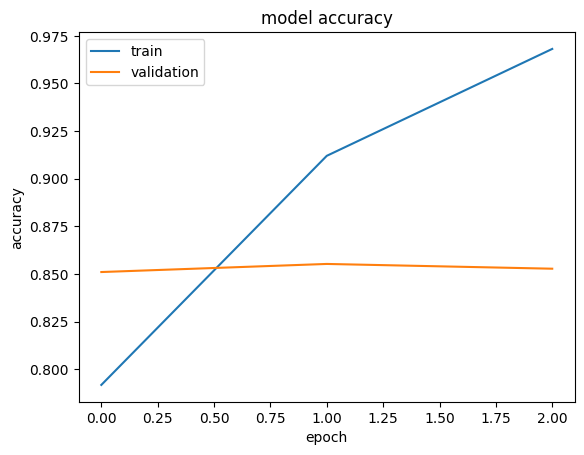

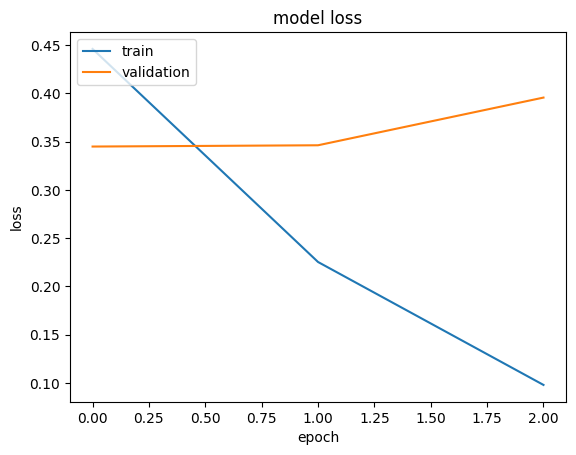

In [ ]:
# Показатели процесса обучения модели

import matplotlib.pyplot as plt

plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc = 'upper left')
plt.show()

In [ ]:
cnn_model.save('cnn_tonal_text.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## RNN архитектура

In [ ]:
from keras.layers import LSTM, GRU

In [ ]:
# Архитектура нейросети

lstm_model = Sequential()
#embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
embedding_layer = Embedding(vocab_length, 100, input_length=maxlen)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(32))

lstm_model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Параметры обучения

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 100)          9203400   
                                                                 
 gru (GRU)                   (None, 32)                12864     
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 9216297 (35.16 MB)
Trainable params: 9216297 (35.16 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
# тренировка модели

lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=4, verbose=1, validation_split=0.2)

Epoch 1/4
250/250 [==============================] - 27s 102ms/step - loss: 0.4762 - acc: 0.7401 - val_loss: 0.3034 - val_acc: 0.8763
Epoch 2/4
250/250 [==============================] - 15s 61ms/step - loss: 0.2035 - acc: 0.9256 - val_loss: 0.2972 - val_acc: 0.8826
Epoch 3/4
250/250 [==============================] - 11s 46ms/step - loss: 0.1052 - acc: 0.9676 - val_loss: 0.3174 - val_acc: 0.8756
Epoch 4/4
250/250 [==============================] - 10s 40ms/step - loss: 0.0562 - acc: 0.9847 - val_loss: 0.3989 - val_acc: 0.8631


In [ ]:
# Вычисляем метрику на тестовом наборе данных

score = lstm_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 1s 4ms/step - loss: 0.3999 - acc: 0.8637


In [ ]:
# Показатели модели

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.4889813959598541
Test Accuracy: 0.8689000010490417


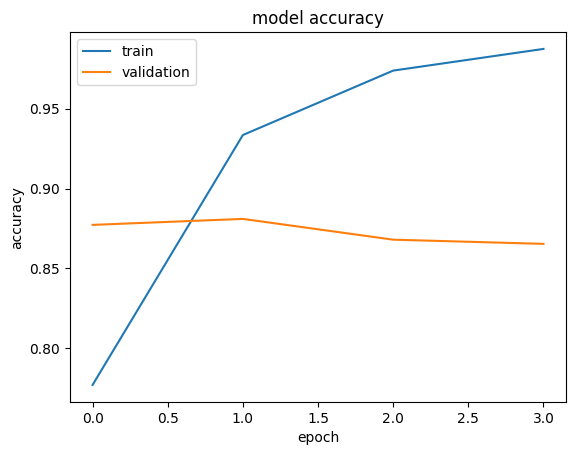

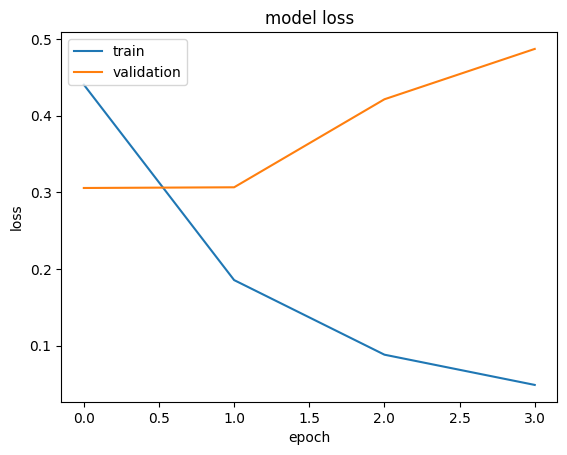

In [ ]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

In [ ]:
lstm_model.save('lstm_tonal_text.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Делаем предсказания

In [ ]:
!ls

cnn_tonal_text.h5  conv_tonal_text.h5  drive  lstm_tonal_text.h5  sample_data


In [ ]:
# загружаем модель

from keras.models import load_model


pretrained_lstm_model = load_model('lstm_tonal_text.h5')



In [ ]:

# импортируем imdb
sample_reviews = pd.read_csv("drive/MyDrive/a3_IMDb_Unseen_Reviews.csv")

sample_reviews.head(6)

,Unnamed: 0,Movie,Review Text,IMDb Rating
0,0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9
1,1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10
2,2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3
3,3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1
4,4,Eternals,Amazing visuals and philosophical concepts!\n\...,10
5,5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3


In [ ]:
# Предварительно обрабатываем текст

unseen_reviews = sample_reviews['Review Text']

unseen_processed = []
for review in unseen_reviews:
  review = preprocess_text(review)
  unseen_processed.append(review)

In [ ]:
# токенизируем текст с помощью ранее обученного токенизатора
unseen_tokenized = word_tokenizer.texts_to_sequences(unseen_processed)

# изменяем длину до 100 слов
unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=maxlen)

In [ ]:
# Пропускаем через модель
unseen_sentiments = lstm_model.predict(unseen_padded)

unseen_sentiments

1/1 [==============================] - 0s 367ms/step


array([[0.99759644],
       [0.9956995 ],
       [0.01147006],
       [0.00523628],
       [0.99902475],
       [0.00447761]], dtype=float32)

In [ ]:
# Writing model output file back to Google Drive

sample_reviews['Predicted Sentiments'] = np.round(unseen_sentiments*10,1)

df_prediction_sentiments = pd.DataFrame(sample_reviews['Predicted Sentiments'], columns = ['Predicted Sentiments'])
df_movie                 = pd.DataFrame(sample_reviews['Movie'], columns = ['Movie'])
df_review_text           = pd.DataFrame(sample_reviews['Review Text'], columns = ['Review Text'])
df_imdb_rating           = pd.DataFrame(sample_reviews['IMDb Rating'], columns = ['IMDb Rating'])


dfx=pd.concat([df_movie, df_review_text, df_imdb_rating, df_prediction_sentiments], axis=1)

#dfx.to_csv("./c2_IMDb_Unseen_Predictions.csv", sep=',', encoding='UTF-8')

dfx.head(6)

,Movie,Review Text,IMDb Rating,Predicted Sentiments
0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9,10.0
1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10,10.0
2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3,0.1
3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1,0.1
4,Eternals,Amazing visuals and philosophical concepts!\n\...,10,10.0
5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3,0.0


In [ ]:
tokenizer_json = word_tokenizer.to_json()
with open('tokenizer_tonal.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [ ]:
import json

In [ ]:
# with open('tokenizer_tonal.json') as f:
#     data = json.load(f)
#     tokenizer = tokenizer_from_json(data)